In [9]:
import numpy as np, matplotlib.pyplot as plt, glob, os, pandas as pd, copy, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm, json
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import shapely.ops, shapely.geometry as geom
from skimage.measure import label
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import imageio, regex as re, joblib as jl

In [10]:
fnameP = 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.filtered2.npy'
fnameA = 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.filtered2.npy'
fnames = [fnameP, fnameA]

In [11]:
fnames = [[x for x in glob.glob('\\\\?\\Z:\\behavior\\*\\wavelet\\{}'.format(fn)) if 'RIG' not in x] for fn in fnames]
len(fnames[0]), len(fnames[1])

(21, 21)

In [12]:
# Find recording information
fnamesRecordingInfo = [[os.path.join(os.path.dirname(os.path.dirname(x)), 
    'recording.json') for x in fn] for fn in fnames]

def loadJSON(x):
    if os.path.exists(x):
        with open(x, 'r') as f:
            return json.load(f)
    else:
        return None
    
recordingInfo = [[loadJSON(x) for x in fn] for fn in fnamesRecordingInfo]

# Exclude recordings that are incomplete or invalid
useRecording = [[('stages' in ri and (isinstance(ri['stages']['radii'], list) or ri['stages']['radii'] > 0) and \
    ri['web_complete'] and ri['tracking_successful']) for ri in _recordingInfo] \
        for _recordingInfo in recordingInfo]

fnames = [[x for x, b in zip(fnames[k], useRecording[k]) if b] for k in range(len(fnames))]
recordingInfo = [[x for x, b in zip(recordingInfo[k], useRecording[k]) if b] for k in range(len(fnames))]

len(fnames[0]), len(fnames[1])

(21, 21)

In [ ]:
# Fill in missing stage information, if necessary
for z in tqdm(range(len(recordingInfo)), leave=False):
    for i in tqdm(range(len(recordingInfo[z])), leave=False):
        s = recordingInfo[z][i]
        # Find position/orientation
        s['fname'] = glob.glob(os.path.abspath(os.path.join(fnames[z][i], 
            '../../croprot/*dlc_position_orientation.npy')))[0]

        # Does this recording.json file specify stage ranges, or starting points?
        for st in s['stages']:
            if s['stages'][st] == []:
                s['stages'][st] = []
            elif not isinstance(s['stages'][st][0], list):
                s['stages'][st] = [s['stages'][st], ]
        
        s['stagesOrg'] = copy.deepcopy(s['stages'])

In [ ]:
# Load AVI indices (computed in )
idxsAVI = []
for fnameIdx in tqdm(range(len(fnames[0]))):
    # Load AVI mapping
    suffix = 'avimapping2.npy'
    fnameAVImapping = glob.glob(os.path.abspath(os.path.join(os.path.dirname(
        fnames[0][fnameIdx]), '../raw/*_{}'.format(suffix))))[0]
    aviMapping = np.load(fnameAVImapping)
    # Already exists?
    fnameAVIidx = fnameAVImapping.replace('.npy', '') + '_idx.npy'
    lensAVI = []
    aviIDs = np.sort([int(re.search('-([0-9]*)\\.avi', x).group(1)) for x in glob.glob(
        fnameAVImapping.replace('_{}'.format(suffix), '*.avi'))])
    i0 = aviIDs[aviMapping[:,1].min()]
    i1 = aviIDs[aviMapping[:,1].max()]
    print('Using movie chunks {} -> {}'.format(i0, i1))
    for aviID in range(i0, i1+1):
        fnameAVI = fnameAVImapping.replace('_{}'.format(suffix), '-{:04}.avi').format(aviID)
        if not os.path.exists(fnameAVI):
            fnameAVI = fnameAVImapping.replace('_{}'.format(suffix), '-{}.avi').format(aviID)
        if not os.path.exists(fnameAVI):
            lensAVI.append(lensAVI[-1])
        else:
            r = imageio.get_reader(fnameAVI)
            lensAVI.append(len(r))
            r.close()
            del r
    
    # Map recording indices to AVI indices
    _aviMappingIdxs = [list(range(i0, i1+1)).index(aviIDs[x]) for x in aviMapping[:,1]]
    idxAVI = np.hstack([np.full(L, i in _aviMappingIdxs,dtype=np.bool) for L, i in zip(lensAVI, range(
        i0, i1+1))])
    # Store
    idxsAVI.append(idxAVI)

In [64]:
def getStartIdxAVI(recID):
    fnameXY = glob.glob(os.path.abspath(os.path.join(os.path.dirname(fnames[0][recID]), 
        '../croprot/*_dlc_position_orientation.npy')))[0]

    endFirstStage = int(np.sort(np.hstack([np.array(x).flatten() for x \
        in recordingInfo[0][recID]['stages'].values()]))[1])
    
    arrXY = np.load(fnameXY)[:endFirstStage, 0:2]

    vels = pd.DataFrame(np.linalg.norm(arrXY - pd.DataFrame(
        arrXY).shift(-50).values, axis=1)).fillna(method='ffill').fillna(method='bfill').values[:,0]
    vels[(vels < 5)] = 0

    _s0 = np.argwhere(np.cumsum(vels) >= 0.10 * np.max(np.cumsum(vels)))[0,0]
    startIdxAVI = np.argwhere(idxAVI)[_s0, 0]
    return startIdxAVI

In [7]:
#jl.dump(idxsAVI, 'C:/Users/acorver/Desktop/paper-figures/recording-duration.pickle')

['C:/Users/acorver/Desktop/paper-figures/recording-duration.pickle']

In [ ]:
stageDistances = {}
stageDurations = {}
PIXEL_TO_CM = 10 / 1000
MINTRAVEL_1SEC = 5
MAXTRAVEL_1SEC = 500
for stage in tqdm(recordingInfo[1][0]['stagesOrg'], leave=False):
    for recid, (recInfo, idxAVI) in tqdm(enumerate(zip(recordingInfo[1], idxsAVI)), leave=False):
        try:
            xy = np.load(recInfo['fname'])[:,0:2]
            idx = np.full(xy.shape[0], False, dtype=np.bool)
            dur = 0
            minTimestampAVI = getStartIdxAVI(recid)
            
            for t0, t1 in recInfo['stagesOrg'][stage]:
                # Create boolean index
                idx[t0:t1] = True
                #print(recInfo['fname'], stage, recid)
                _t0 = min(t0, np.sum(idxAVI)-1)
                _t1 = min(t1, np.sum(idxAVI)-1)
                _start = np.argwhere(idxAVI)[_t0, 0]
                # Modify based on 10%-distance-traveled rule?
                if _start < minTimestampAVI:
                    print('Modifying start time from {} to {} for recording {} stage {}'.format(
                        _start, minTimestampAVI, recid, stage))
                    _start = minTimestampAVI
                # Compute duration
                dur += (np.argwhere(idxAVI)[_t1, 0] - _start)
            a = np.linalg.norm(np.diff(xy[idx][::50,:], axis=0), axis=1)
            a = np.nansum(a[(a > MINTRAVEL_1SEC)&(a < MAXTRAVEL_1SEC)])
            if stage not in stageDistances:
                stageDistances[stage] = []
                stageDurations[stage] = []
            stageDistances[stage].append(a * PIXEL_TO_CM)
            stageDurations[stage].append(dur * 0.02)
            #stageDurations[stage].append(np.sum(idx) * 0.02)
        except Exception as e:
            print(e)

In [76]:
tblDurations = []
for stage in stageDurations:
    for recid, d in enumerate(stageDurations[stage]):
        tblDurations.append((stage, d / 3600, recid))
tblDurations = pd.DataFrame(tblDurations, columns=['stage', 'minutes', 'recid'])
tblDurations.loc[:,'minutes_total'] = tblDurations.groupby('recid').transform('sum').minutes

In [77]:
def _fn(x):
    return tblDurations.loc[[i for i, v in zip(x.index, x.values) if v in [
        'radii', 'spiral_cap', 'stabilimentum']], 'minutes'].sum()
tblDurations.loc[:,'minutes_finalstructure'] = tblDurations.groupby('recid').transform(_fn).stage

In [78]:
tblDistances = []
for stage in stageDistances:
    for recid, d in enumerate(stageDistances[stage]):
        tblDistances.append((stage, d * 0.01, recid))
tblDistances = pd.DataFrame(tblDistances, columns=['stage', 'meters', 'recid'])
tblDistances.loc[:,'meters_total'] = tblDistances.groupby('recid').transform('sum').meters

### Plot

In [79]:
# Exclude two-aux-spiral recordings from whiskers, because the radii (and other) 
# stages are extended for circadian reasons
outliersIdxs = [i for i, x in enumerate(recordingInfo[0]) if len(x['stages']['spiral_aux']) > 0 and isinstance(
    x['stages']['spiral_aux'][0], list) and len(x['stages']['spiral_aux']) >= 2]
outliersIdxs

[3]

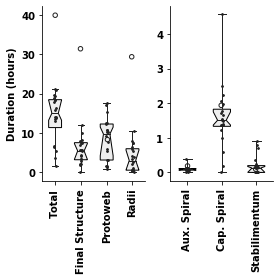

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(4,4))

for istage, stage in enumerate(['total','finalstructure','protoweb','radii','spiral_aux','spiral_cap','stabilimentum']):
    if istage <= 3:
        ax = axs[0]
    else:
        ax = axs[1]
    
    if stage != 'total' and stage != 'finalstructure':
        yvals = tblDurations.minutes[(tblDurations.stage == stage)&(
            ~tblDurations.recid.isin(outliersIdxs))]
    elif stage == 'total':
        yvals = tblDurations.minutes_total[(tblDurations.stage=='protoweb')&(
            ~tblDurations.recid.isin(outliersIdxs))]
    elif stage == 'finalstructure':
        yvals = tblDurations.minutes_finalstructure[(tblDurations.stage=='protoweb')&(
            ~tblDurations.recid.isin(outliersIdxs))]
    
    xvals = np.ones(yvals.size) * istage + 0 + (np.random.random(size=yvals.size) - 0.5) * 0.1
    ax.scatter(xvals, yvals, s=3, color='#222222', zorder=10)
    
    bp = ax.boxplot(yvals, patch_artist=True, bootstrap=10000, widths=[0.5,],
        notch=True, vert=True, whis=(0,100), positions=(istage,))
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
    # Plot outliers
    if stage != 'total' and stage != 'finalstructure':
        yvals = tblDurations.minutes[(tblDurations.stage == stage)&(
            tblDurations.recid.isin(outliersIdxs))]
    elif stage == 'total':
        yvals = tblDurations.minutes_total[(tblDurations.stage=='protoweb')&(
            tblDurations.recid.isin(outliersIdxs))]
    elif stage == 'finalstructure':
        yvals = tblDurations.minutes_finalstructure[(tblDurations.stage=='protoweb')&(
            tblDurations.recid.isin(outliersIdxs))]
    ax.scatter(xvals[:yvals.size], yvals, 
        s=20, zorder=10, facecolors='none', edgecolors='#222222')

axs[0].set_xticks([0, 1, 2, 3])
axs[0].set_xticklabels(['Total', 'Final Structure', 'Protoweb', 'Radii'], rotation=90)
axs[0].set_ylabel('Duration (hours)')
[axs[0].spines[x].set_visible(False) for x in ['top', 'right']]

axs[1].set_xticks([4, 5, 6])
axs[1].set_xticklabels(['Aux. Spiral', 'Cap. Spiral', 'Stabilimentum'], rotation=90)
[axs[1].spines[x].set_visible(False) for x in ['top', 'right']]

fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_recording_durations_v3_10perccorrection.pdf')

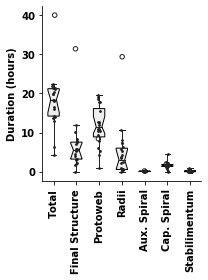

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(3,4))

for istage, stage in enumerate(['total','finalstructure','protoweb','radii','spiral_aux','spiral_cap','stabilimentum']):
    if stage != 'total' and stage != 'finalstructure':
        yvals = tblDurations.minutes[(tblDurations.stage == stage)&(
            ~tblDurations.recid.isin(outliersIdxs))]
    elif stage == 'total':
        yvals = tblDurations.minutes_total[(tblDurations.stage=='protoweb')&(
            ~tblDurations.recid.isin(outliersIdxs))]
    elif stage == 'finalstructure':
        yvals = tblDurations.minutes_finalstructure[(tblDurations.stage=='protoweb')&(
            ~tblDurations.recid.isin(outliersIdxs))]
    
    xvals = np.ones(yvals.size) * istage + 0 + (np.random.random(size=yvals.size) - 0.5) * 0.1
    ax.scatter(xvals, yvals, s=3, color='#222222', zorder=10)
    
    bp = ax.boxplot(yvals, patch_artist=True, bootstrap=10000, widths=[0.5,],
        notch=True, vert=True, whis=(0,100), positions=(istage,))
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
    # Plot outliers
    if stage != 'total' and stage != 'finalstructure':
        yvals = tblDurations.minutes[(tblDurations.stage == stage)&(
            tblDurations.recid.isin(outliersIdxs))]
    elif stage == 'total':
        yvals = tblDurations.minutes_total[(tblDurations.stage=='protoweb')&(
            tblDurations.recid.isin(outliersIdxs))]
    elif stage == 'finalstructure':
        yvals = tblDurations.minutes_finalstructure[(tblDurations.stage=='protoweb')&(
            tblDurations.recid.isin(outliersIdxs))]
    ax.scatter(xvals[:yvals.size], yvals, 
        s=20, zorder=10, facecolors='none', edgecolors='#222222')
    
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Total', 'Final Structure', 'Protoweb', 'Radii', 'Aux. Spiral', 
                    'Cap. Spiral', 'Stabilimentum'], rotation=90)
ax.set_ylabel('Duration (hours)')

[ax.spines[x].set_visible(False) for x in ['top', 'right']]

fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_recording_durations_v2.pdf')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3,4))

for istage, stage in enumerate(['total','finalstructure','protoweb','radii','spiral_aux','spiral_cap','stabilimentum']):
    if stage != 'total' and stage != 'finalstructure':
        yvals = tblDurations.minutes[tblDurations.stage == stage]
    elif stage == 'total':
        yvals = tblDurations.minutes_total[tblDurations.stage=='protoweb']
    elif stage == 'finalstructure':
        yvals = tblDurations.minutes_finalstructure[tblDurations.stage=='protoweb']
    
    xvals = np.ones(yvals.size) * istage + 0 + (np.random.random(size=yvals.size) - 0.5) * 0.1
    ax.scatter(xvals, yvals, s=3, color='#222222', zorder=10)
    
    bp = ax.boxplot(yvals, patch_artist=True, bootstrap=10000, widths=[0.5,],
        notch=True, vert=True, whis=(0,100), positions=(istage,))
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Total', 'Final Structure', 'Protoweb', 'Radii', 'Aux. Spiral', 
                    'Cap. Spiral', 'Stabilimentum'], rotation=90)
ax.set_ylabel('Duration (hours)')

[ax.spines[x].set_visible(False) for x in ['top', 'right']]

fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_recording_durations_v2.pdf')

C:\Users\acorver\.conda\envs\spider\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


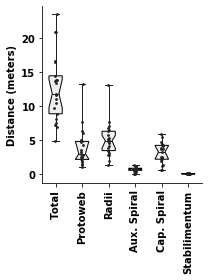

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(3,4))

for istage, stage in enumerate(['total','protoweb','radii','spiral_aux','spiral_cap','stabilimentum']):
    if stage != 'total':
        yvals = tblDistances.meters[tblDistances.stage == stage]
    else:
        yvals = tblDistances.meters_total[tblDistances.stage=='protoweb']
    
    xvals = np.ones(yvals.size) * istage + 0 + (np.random.random(size=yvals.size) - 0.5) * 0.1
    ax.scatter(xvals, yvals, s=3, color='#222222', zorder=10)
    
    bp = ax.boxplot(yvals, patch_artist=True, bootstrap=10000, widths=[0.5,],
        notch=True, vert=True, whis=(0,100), positions=(istage,))
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='#222222')
    plt.setp(bp['boxes'], facecolor='#eeeeee')
    
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['Total', 'Protoweb', 'Radii', 'Aux. Spiral', 'Cap. Spiral', 'Stabilimentum'], rotation=90)
ax.set_ylabel('Distance (meters)')

[ax.spines[x].set_visible(False) for x in ['top', 'right']]

fig.show()
fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_recording_distances.pdf')